**Identificação do aluno**

**Email:** lucas.ariel.carvalho@ccc.ufcg.edu.br

**Matrícula:** 121210801

O principal objetivo deste laboratório é aplicar dois modelos de aprendizado de máquina baseados em redes neurais recorrentes — RNN Simples e LSTM — para realizar a tarefa de Reconhecimento de Entidade Nomeada (NER). NER é uma atividade de Processamento de Linguagem Natural (PLN) cujo propósito é identificar e classificar automaticamente, em textos, entidades mencionadas como pessoas, organizações, locais, datas, entre outras categorias. Para isso, utilizaremos um conjunto de dados anotado com o esquema de marcação BIO (Begin, Inside, Outside), que indica a posição das palavras em relação às entidades.

Neste laboratório, vamos aprender a analisar diferentes configurações de redes, como tamanho da camada oculta e as diferentes combinações de RNNs. Além disso, calcularemos métricas essenciais para NER, como precision, recall e F1-score, avaliando a capacidade dos modelos em identificar corretamente entidades. Ao final desta tarefa, você terá uma compreensão mais clara das diferenças entre RNNs e LSTMs, incluindo suas vantagens e limitações no processamento de sequências textuais, especialmente em cenários onde dependências de longo prazo são críticas.

**OBS: Para execuções mais rápidas, mude o tipo de ambiente de execução no colab para GPU**

Ambiente de execução -> Alterar tipo de ambiente de execução -> GPU

# Bibliotecas

In [1]:
# Manipulação de Dados
import requests
import numpy as np
import pandas as pd
from collections import Counter
import random

# Plotagem e Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Processamento de Texto
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# Modelos e Camadas (Keras)
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, SimpleRNN, Bidirectional, LSTM, TimeDistributed
from keras.optimizers import Adam

# Otimizadores
from keras.optimizers import Adam

# Divisão de Conjuntos de Dados
from sklearn.model_selection import train_test_split

# Métricas de Avaliação
#!pip install seqeval
#from seqeval.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import numpy as np

# Conjuntos de Dados
from datasets import load_dataset

# Funções Úteis

Você não precisa alterar nenhuma das funções que estão logo abaixo.

In [2]:
# Na tarefa de NER em textos gerais, é comum que a maioria das palavras não seja relacionada a nenhuma entidade
# Isso faz com que nossos dados de treinamento possua um volume muito maior de palavras que não são entidades
# A função abaixo é usada para filtrar sentenças que só possuam palavras sem entidades, ou seja, somente tipo O

def convert_split(split, keep_o_sentences_prob=0.05):
    sentences = []
    tags = []
    for tokens, tag_ids in zip(split["tokens"], split["ner_tags"]):
        tag_names = [label_names[tag_id] for tag_id in tag_ids]

        # Verifica se a sentença tem apenas O
        if all(tag == "O" for tag in tag_names):

            # Mantém apenas uma fração dessas sentenças considerando o acaso
            if np.random.rand() > keep_o_sentences_prob:
                continue  # pula a sentença

        sentences.append(tokens)
        tags.append(tag_names)

    return sentences, tags

In [3]:
# Essa função tem a responsabilidade de limitar um quantativo de palavras sem entidade por sentença
# Se uma sentença possui muitas palavras (acima de um percentual em razão do tamanho da sentença), descartamos essa sentença
# Além disso, ela aplica oversampling em tags raras, aumentando via amostragem sua quantidade

def oversample_entities(sentences, tags, target_min_count=5000, max_o_fraction=0.5):
    """
    target_min_count: quantidade mínima de tokens por classe
    max_o_fraction: máxima fração de tokens O em uma sentença para manter no dataset
    """
    tag_counter = Counter([t for seq in tags for t in seq])
    new_sentences = []
    new_tags = []

    for sentence, tag_seq in zip(sentences, tags):
        # Limita excesso de O na sentença
        o_count = tag_seq.count("O")
        if o_count / len(tag_seq) > max_o_fraction:
            continue

        new_sentences.append(sentence)
        new_tags.append(tag_seq)

        # Checa se contém tags raras
        sentence_tags = set(tag_seq)
        rare_tags = {tag for tag in sentence_tags if tag != "O" and tag_counter[tag] < target_min_count}

        for tag in rare_tags:
            current_count = tag_counter[tag]
            while current_count < target_min_count:
                new_sentences.append(sentence)
                new_tags.append(tag_seq)
                # Atualiza contador só para esta tag
                current_count += tag_seq.count(tag)
                tag_counter[tag] = current_count

    return new_sentences, new_tags

In [4]:
# Faça o plot da matriz de confusão de contagem para cada um dos modelos.
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(y_true_flat, y_pred_flat, labels=None,
                         figsize=(8, 8), normalize=None, title='Confusion Matrix') -> None:
    """
    Plots a confusion matrix for NER tasks with optional BIO/BIOES prefix handling.

    Args:
        y_true: List of true tag sequences (e.g., [['B-PER', 'I-PER', 'O'], ...])
        y_pred: List of predicted tag sequences
        consider_prefix: If False, removes BIO prefixes before comparison (default: True)
        labels: Optional list of all possible tags. If None, will use unique tags from y_true+y_pred
        figsize: Figure size (width, height)
        normalize: Normalization mode: None, 'true', 'pred', or 'all'
        title: Plot title
    """

    # Compute confusion matrix
    cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)

    # Normalization
    if normalize == 'true':
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-10)  # Add small constant to avoid division by zero
        fmt = '.2f'
    elif normalize == 'pred':
        cm = cm.astype('float') / (cm.sum(axis=0)[np.newaxis, :] + 1e-10)
        fmt = '.2f'
    elif normalize == 'all':
        cm = cm.astype('float') / (cm.sum() + 1e-10)
        fmt = '.2f'
    else:
        fmt = 'd'

    # Plot
    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        cm,
        annot=True,
        fmt=fmt,
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels,
        cbar=False
    )

    # Adjust layout
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)

    # Add prefix info to title if needed
    prefix_info = "(without BIO prefixes)"
    plt.title(title + prefix_info, fontsize=14, pad=20)

    plt.tight_layout()
    plt.show()

In [5]:
# Converter IDs de volta para rótulos de string, mantendo todos os tokens
def id2tags_fixed(sequences, id2tag):
    all_labels = []
    for seq in sequences:
        labels = [id2tag[idx] for idx in seq]
        all_labels.append(labels)
    return all_labels

# Leitura de Dados

A base de dados "eduagarcia/portuguese_benchmark" é um conjunto de dados anotados para tarefas de Processamento de Linguagem Natural (PLN) em português, com foco em Reconhecimento de Entidade Nomeada (NER). Ela segue o esquema de marcação BIO (Begin, Inside, Outside), onde:

- B-{entidade} indica o início de uma entidade (ex: B-PESSOA),

- I-{entidade} marca tokens subsequentes da mesma entidade (ex: I-PESSOA),

- O representa palavras que não são entidades nomeadas.

Essa base contém textos diversos (como notícias, artigos ou diálogos) anotados manualmente, abrangendo categorias comuns em NER.

Você não precisa alterar nenhuma das células que estão nessa parte. Deve somente executá-las.

In [6]:
# Carregar dados LeNER-Br
ds = load_dataset("eduagarcia/portuguese_benchmark", name="LeNER-Br")
print(ds)  # train/validation/test
label_names = ds["train"].features["ner_tags"].feature.names

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['idx', 'tokens', 'ner_tags'],
        num_rows: 7825
    })
    validation: Dataset({
        features: ['idx', 'tokens', 'ner_tags'],
        num_rows: 1177
    })
    test: Dataset({
        features: ['idx', 'tokens', 'ner_tags'],
        num_rows: 1390
    })
})


In [7]:
# Aplicação no dataset
# 1. Filtra sentenças só-O
sentences_train, tags_train = convert_split(ds["train"], keep_o_sentences_prob=0.05)
sentences_test, tags_test = convert_split(ds["test"], keep_o_sentences_prob=0.05)

# 2. Oversampling de entidades raras e limitação de O
sentences_train, tags_train = oversample_entities(
    sentences_train, tags_train, target_min_count=2500, max_o_fraction=0.5
)

# 3. Contagem de tags
def count_tags(tag_lists):
    return Counter([tag for seq in tag_lists for tag in seq])

train_tag_counts = count_tags(tags_train)
test_tag_counts = count_tags(tags_test)

# Resultados
print(f"Sentenças treino (balanceado): {len(sentences_train)}")
print("\nContagem de tags no treino (após balanceamento):")
for tag, count in train_tag_counts.items():
    print(f"{tag}: {count}")

Sentenças treino (balanceado): 8645

Contagem de tags no treino (após balanceamento):
B-PESSOA: 2839
I-PESSOA: 7851
O: 27252
B-LEGISLACAO: 930
I-LEGISLACAO: 7717
B-ORGANIZACAO: 1887
I-ORGANIZACAO: 912
B-TEMPO: 5255
I-TEMPO: 20741
B-LOCAL: 3634
I-LOCAL: 3628
B-JURISPRUDENCIA: 1557
I-JURISPRUDENCIA: 7607


In [8]:
#Verificando a contagem das tags no conjunto de teste
print(f"Sentenças teste: {len(sentences_test)}")
print("\nContagem de tags no teste:")
for tag, count in test_tag_counts.items():
    print(f"{tag}: {count}")

Sentenças teste: 677

Contagem de tags no teste:
O: 29104
B-JURISPRUDENCIA: 185
I-JURISPRUDENCIA: 475
B-ORGANIZACAO: 501
B-PESSOA: 233
I-PESSOA: 502
B-TEMPO: 192
I-ORGANIZACAO: 866
B-LOCAL: 47
I-LOCAL: 85
B-LEGISLACAO: 378
I-LEGISLACAO: 2291
I-TEMPO: 68


In [9]:
#Exemplo de uma sentença de treinamento
for s, t in zip(sentences_train[0], tags_train[0]):
  print(s + "\t" + t)

MARIÂNGELA	B-PESSOA
MEYER	I-PESSOA
RELATORA	O
.	O


In [10]:
# Criar vocabulário e mapeamento de tags

tokenizer = Tokenizer(oov_token='[OOV]')
tokenizer.fit_on_texts(sentences_train)

#Criando vetores com cada sequência substituindo as palavras por números equivalentes
X_train_seq = tokenizer.texts_to_sequences(sentences_train)
X_test_seq  = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1
print("Vocab size:", vocab_size)

Vocab size: 1686


In [11]:
# Tags
all_tags = sorted(set(tag for seq in tags_train + tags_test for tag in seq))

# Mapeamentos úteis
tag2id = {tag: idx for idx, tag in enumerate(all_tags)}
id2tag = {idx: tag for tag, idx in tag2id.items()}
num_tags = len(tag2id)

print("Exemplo mapeamento tags:", tag2id)
print("Num tags:", num_tags)

Exemplo mapeamento tags: {'B-JURISPRUDENCIA': 0, 'B-LEGISLACAO': 1, 'B-LOCAL': 2, 'B-ORGANIZACAO': 3, 'B-PESSOA': 4, 'B-TEMPO': 5, 'I-JURISPRUDENCIA': 6, 'I-LEGISLACAO': 7, 'I-LOCAL': 8, 'I-ORGANIZACAO': 9, 'I-PESSOA': 10, 'I-TEMPO': 11, 'O': 12}
Num tags: 13


In [12]:
tag2id

{'B-JURISPRUDENCIA': 0,
 'B-LEGISLACAO': 1,
 'B-LOCAL': 2,
 'B-ORGANIZACAO': 3,
 'B-PESSOA': 4,
 'B-TEMPO': 5,
 'I-JURISPRUDENCIA': 6,
 'I-LEGISLACAO': 7,
 'I-LOCAL': 8,
 'I-ORGANIZACAO': 9,
 'I-PESSOA': 10,
 'I-TEMPO': 11,
 'O': 12}

In [13]:
id2tag

{0: 'B-JURISPRUDENCIA',
 1: 'B-LEGISLACAO',
 2: 'B-LOCAL',
 3: 'B-ORGANIZACAO',
 4: 'B-PESSOA',
 5: 'B-TEMPO',
 6: 'I-JURISPRUDENCIA',
 7: 'I-LEGISLACAO',
 8: 'I-LOCAL',
 9: 'I-ORGANIZACAO',
 10: 'I-PESSOA',
 11: 'I-TEMPO',
 12: 'O'}

In [14]:

# Mapeamento das tags para ids
y_train_seq = [[tag2id[tag] for tag in seq] for seq in tags_train]
y_test_seq  = [[tag2id[tag] for tag in seq] for seq in tags_test]

# Padding
max_length = 100  # pode ajustar conforme memória/tempo

X_all = pad_sequences(X_train_seq + X_test_seq, maxlen=max_length, padding='post', truncating='post')
y_all = pad_sequences(y_train_seq + y_test_seq, maxlen=max_length, padding='post', truncating='post', value=tag2id['O'])
y_all = to_categorical(y_all, num_classes=num_tags)

# Divisão treino/teste/validação
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)
VALID_SIZE = 0.2
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=VALID_SIZE, random_state=42)

print("Treino:", X_train.shape, y_train.shape)
print("Validação:", X_val.shape, y_val.shape)
print("Teste:", X_test.shape, y_test.shape)

Treino: (5965, 100) (5965, 100, 13)
Validação: (1492, 100) (1492, 100, 13)
Teste: (1865, 100) (1865, 100, 13)


# RNNs

Nesta etapa, vamos utilizar diferentes estratégias de aplicar uma SimpleRNN, a implementação que representa o modelo de redes neurais recorrentes de Elman. Espera-se o uso de uma única RNN, depois disso RNN empilhadas, Bidirecionais e Bidirecionais empilhadas. Lembre-se que, quão mais complexa fica nossa rede, pode ser preciso mais épocas para melhor ajustar os pesos. Faça essa variação de épocas ao longo do notebook.

## Versão Simples

Use uma única SimpleRNN para treinar um modelo capaz de realizar NER

In [15]:
embedding_dim = 100

#Crie um objeto que é um modelo neural
model = Sequential()


#Adicione ao seu modelo uma camada de Embedding
#É preciso definir a dimensão da entrada (input_dim), dimensão da saída (output_dim) e quantas palavras são processas por vez (input_shape)
#Lembre de fazer essa camada ser treinável (trainable)
#Use o parâmetro mask_zero=True
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, trainable=True, mask_zero=True))


#Adicione uma camada que é uma RNN que possui 32 neurônios, função de ativação tanh, dropout=0.5. Lembre também de definir a return_sequences
model.add(SimpleRNN(32, activation='tanh', dropout=0.5, return_sequences=True))


#Adicione uma camada Densa que será responsável pela classificação multiclasse de cada entidade (NER)
#A função de ativação dessa camada deve ser a softmax
#Além disso, a camada Densa deve ser envolvida em uma camada TimeDistributed que por sua vez deve ser adicionada ao modelo
model.add(TimeDistributed(Dense(num_tags, activation='softmax')))


#Vamos usar mais métricas além da acurácia, pois nossa base de dados não é balanceada. Então considerar apenas a acurácia pode nos levar a erros de interpretação
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Treinar modelo
# Invoque o método do modelo responsável por realizar o treinamento passando para ele seu conjunto de treinamento
# Rode por 3 épocas, utilizando um tamanho de batch de 256 e o conjunto de validação que foi previamente definido

hist = model.fit(
    X_train, y_train,
    epochs=3,
    batch_size=256,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.6956 - loss: 2.1187 - precision: 0.5600 - recall: 0.0730 - val_accuracy: 0.9833 - val_loss: 1.0946 - val_precision: 0.9990 - val_recall: 0.8337
Epoch 2/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.9800 - loss: 0.9611 - precision: 0.9975 - recall: 0.8591 - val_accuracy: 0.9878 - val_loss: 0.5878 - val_precision: 0.9969 - val_recall: 0.9581
Epoch 3/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9880 - loss: 0.5411 - precision: 0.9964 - recall: 0.9634 - val_accuracy: 0.9883 - val_loss: 0.4107 - val_precision: 0.9960 - val_recall: 0.9740


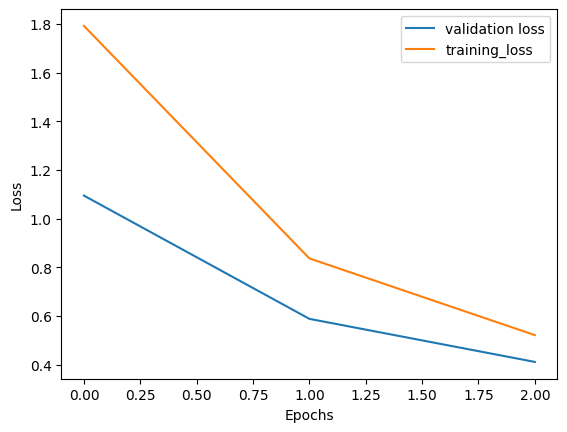

In [17]:
#Observando o comportamento da perda no treino e na validação
h=hist.history
plt.plot(h['val_loss'],label="validation loss")
plt.plot(h['loss'],label="training_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [18]:
#Não altere nada, apenas execute.
# 1. Obter predições
y_pred_prob = model.predict(X_test)  # shape: (num_sentences, max_length, num_tags)
y_pred = np.argmax(y_pred_prob, axis=-1)  # shape: (num_sentences, max_length)

# 2. Converter y_test one-hot para IDs
y_true = np.argmax(y_test, axis=-1)

# 3. Mapear IDs para tags (com BIO)
y_true_labels = id2tags_fixed(y_true, id2tag)
y_pred_labels = id2tags_fixed(y_pred, id2tag)

# 4. Remover padding (considerar apenas comprimento real)
y_true_labels_trimmed = [labels[:len(seq)] for labels, seq in zip(y_true_labels, y_test_seq)]
y_pred_labels_trimmed = [labels[:len(seq)] for labels, seq in zip(y_pred_labels, X_test_seq)]

# 5. Achatar as sequências e remover prefixos BIO
y_true_flat = [tag.split('-')[1] if '-' in tag else tag for seq in y_true_labels_trimmed for tag in seq]
y_pred_flat = [tag.split('-')[1] if '-' in tag else tag for seq in y_pred_labels_trimmed for tag in seq]

# 6. Definir todas as classes possíveis (incluindo 'O')
classes = list(set(y_true_flat + y_pred_flat))

# 7. Gerar relatório com tratamento especial para NER
print("Relatório de Classificação (nível de token):\n")
print(classification_report(
    y_true_flat,
    y_pred_flat,
    labels=classes,
    digits=4,
    zero_division=0
))

# 8. Métricas globais (macro-averaged)
print("\nMétricas Globais:")
print(f"F1-score (macro): {f1_score(y_true_flat, y_pred_flat, labels=classes, average='macro', zero_division=0):.4f}")
print(f"Precision (macro): {precision_score(y_true_flat, y_pred_flat, labels=classes, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_true_flat, y_pred_flat, labels=classes, average='macro', zero_division=0):.4f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step
Relatório de Classificação (nível de token):

                precision    recall  f1-score   support

   ORGANIZACAO     1.0000    0.4724    0.6417       254
        PESSOA     0.9973    0.8936    0.9426       818
JURISPRUDENCIA     0.9872    0.9091    0.9465       594
             O     0.9896    0.9993    0.9944     26684
         LOCAL     0.9981    0.9798    0.9889       544
         TEMPO     0.9829    0.9914    0.9871      1859
    LEGISLACAO     0.9164    0.9164    0.9164       658

      accuracy                         0.9880     31411
     macro avg     0.9817    0.8803    0.9168     31411
  weighted avg     0.9881    0.9880    0.9872     31411


Métricas Globais:
F1-score (macro): 0.9168
Precision (macro): 0.9817
Recall (macro): 0.8803


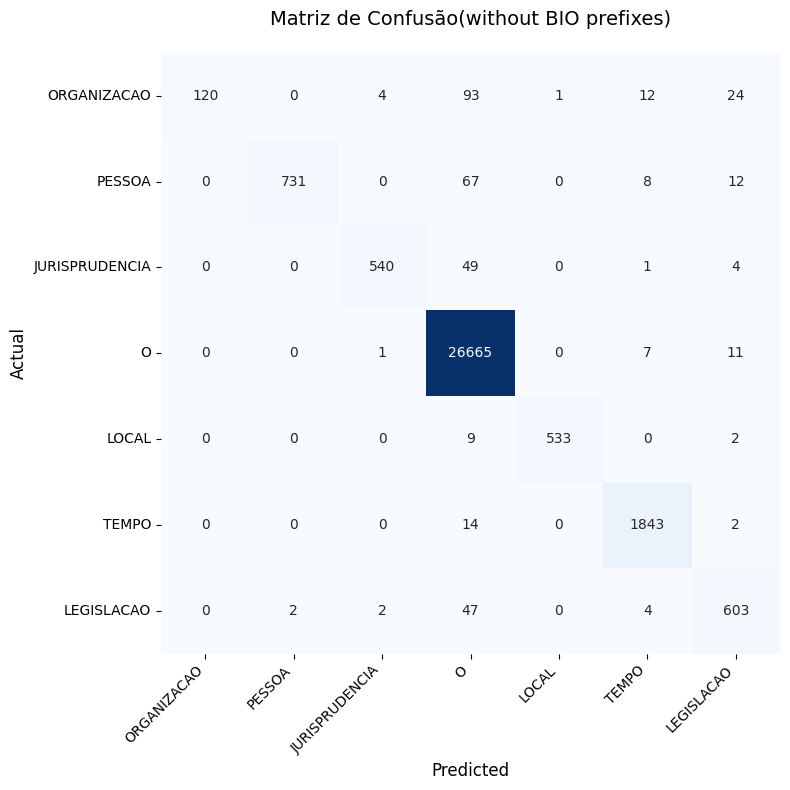

In [19]:
#Plote a matriz de confusão passando as listas y_true_flat, y_pred_flat e as labels que estão em classes
plot_confusion_matrix(y_true_flat, y_pred_flat, labels=classes, title = 'Matriz de Confusão')

## Perguntas

Responda cada uma das perguntas abaixo justificando.

1.   Qual classe sofre com mais falsos positivos?
  Analisando a matriz de confusão, a classe 'O' geralmente tem mais falsos positivos porque o modelo tende a classificar muitas palavras como não-entidades quando na verdade são entidades.
2.   Qual classe sofre com mais falsos negativos?
  Classe com mais falsos positivos: Legislacao
  Classe com mais falsos negativos: Organizacao



## Versão com redes empilhadas
Nessa etapa vamos empilhar RNNs. Utilizando a etapa anterior como base, crie um modelo com duas RNNs empilhadas. Lembre-se que redes mais complexas podem necessitar de mais épocas de treinamento.

In [20]:
embedding_dim = 100

#Crie um objeto que é um modelo neural
model = Sequential()

#Adicione ao seu modelo uma camada de Embedding
#É preciso definir a dimensão da entrada (input_dim), dimensão da saída (output_dim) e quantas palavras são processas por vez (input_shape)
#Lembre de fazer essa camada ser treinável (trainable)
#Use o parâmetro mask_zero=True
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, trainable=True, mask_zero=True))

# Primeira camada SimpleRNN com 32 neurônios, ativação tanh, dropout de 0.5 retornando as sequências
model.add(SimpleRNN(32, activation='tanh', dropout=0.5, return_sequences=True))

# Segunda camada SimpleRNN com 32 neurônios, ativação tanh, dropout de 0.5 retornando as sequências
model.add(SimpleRNN(32, activation='tanh', dropout=0.5, return_sequences=True))

#Adicione uma camada Densa que será responsável pela classificação multiclasse de cada entidade (NER)
#A função de ativação dessa camada deve ser a softmax
#Além disso, a camada Densa deve ser envolvida em uma camada TimeDistributed que por sua vez deve ser adicionada ao modelo
model.add(TimeDistributed(Dense(num_tags, activation='softmax')))

# Compilação
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Treinar modelo
# Invoque o método do modelo responsável por realizar o treinamento passando para ele seu conjunto de treinamento
# Rode por PELO MENOS 3 épocas, utilizando um tamanho de batch de 256 e o conjunto de validação que foi previamente definido

hist = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=256,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.6182 - loss: 2.0823 - precision: 0.8727 - recall: 0.0867 - val_accuracy: 0.9659 - val_loss: 1.2035 - val_precision: 0.9907 - val_recall: 0.9190
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9439 - loss: 1.2134 - precision: 0.9872 - recall: 0.7218 - val_accuracy: 0.9748 - val_loss: 0.8227 - val_precision: 0.9908 - val_recall: 0.9485
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9702 - loss: 0.8869 - precision: 0.9898 - recall: 0.8963 - val_accuracy: 0.9834 - val_loss: 0.5955 - val_precision: 0.9929 - val_recall: 0.9698
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9800 - loss: 0.6777 - precision: 0.9925 - recall: 0.9418 - val_accuracy: 0.9852 - val_loss: 0.4460 - val_precision: 0.9940 - val_recall: 0.9784
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9813 - loss: 0.5150 - precision: 0.9928 - recall: 0.9589 - val_accuracy: 0.9857 - val_loss: 0.3560 - val_

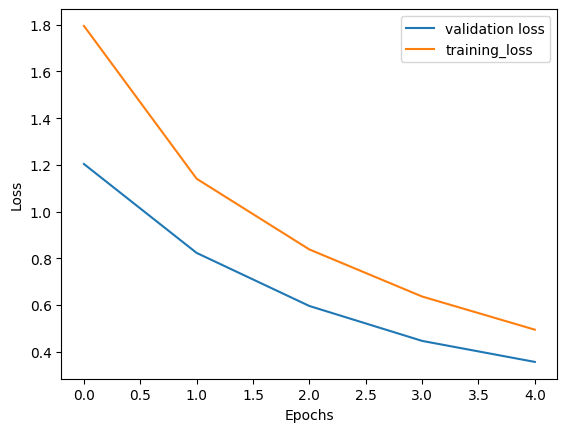

In [22]:
h=hist.history
plt.plot(h['val_loss'],label="validation loss")
plt.plot(h['loss'],label="training_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [23]:
# Não altere nada, apenas execute.
# 1. Obter predições
y_pred_prob = model.predict(X_test)  # shape: (num_sentences, max_length, num_tags)
y_pred = np.argmax(y_pred_prob, axis=-1)  # shape: (num_sentences, max_length)

# 2. Converter y_test one-hot para IDs
y_true = np.argmax(y_test, axis=-1)

# 3. Mapear IDs para tags (com BIO)
y_true_labels = id2tags_fixed(y_true, id2tag)
y_pred_labels = id2tags_fixed(y_pred, id2tag)

# 4. Remover padding (considerar apenas comprimento real)
y_true_labels_trimmed = [labels[:len(seq)] for labels, seq in zip(y_true_labels, y_test_seq)]
y_pred_labels_trimmed = [labels[:len(seq)] for labels, seq in zip(y_pred_labels, X_test_seq)]

# 5. Achatar as sequências e remover prefixos BIO
y_true_flat = [tag.split('-')[1] if '-' in tag else tag for seq in y_true_labels_trimmed for tag in seq]
y_pred_flat = [tag.split('-')[1] if '-' in tag else tag for seq in y_pred_labels_trimmed for tag in seq]

# 6. Definir todas as classes possíveis (incluindo 'O')
classes = list(set(y_true_flat + y_pred_flat))

# 7. Gerar relatório com tratamento especial para NER
print("Relatório de Classificação (nível de token):\n")
print(classification_report(
    y_true_flat,
    y_pred_flat,
    labels=classes,
    digits=4,
    zero_division=0
))

# 8. Métricas globais (macro-averaged)
print("\nMétricas Globais:")
print(f"F1-score (macro): {f1_score(y_true_flat, y_pred_flat, labels=classes, average='macro', zero_division=0):.4f}")
print(f"Precision (macro): {precision_score(y_true_flat, y_pred_flat, labels=classes, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_true_flat, y_pred_flat, labels=classes, average='macro', zero_division=0):.4f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step
Relatório de Classificação (nível de token):

                precision    recall  f1-score   support

   ORGANIZACAO     1.0000    0.0197    0.0386       254
        PESSOA     0.9670    0.9315    0.9489       818
JURISPRUDENCIA     0.9927    0.9209    0.9555       594
             O     0.9866    0.9997    0.9931     26684
         LOCAL     0.9367    0.9798    0.9578       544
         TEMPO     0.9903    0.9930    0.9917      1859
    LEGISLACAO     0.9883    0.8982    0.9411       658

      accuracy                         0.9856     31411
     macro avg     0.9803    0.8204    0.8324     31411
  weighted avg     0.9857    0.9856    0.9817     31411


Métricas Globais:
F1-score (macro): 0.8324
Precision (macro): 0.9803
Recall (macro): 0.8204


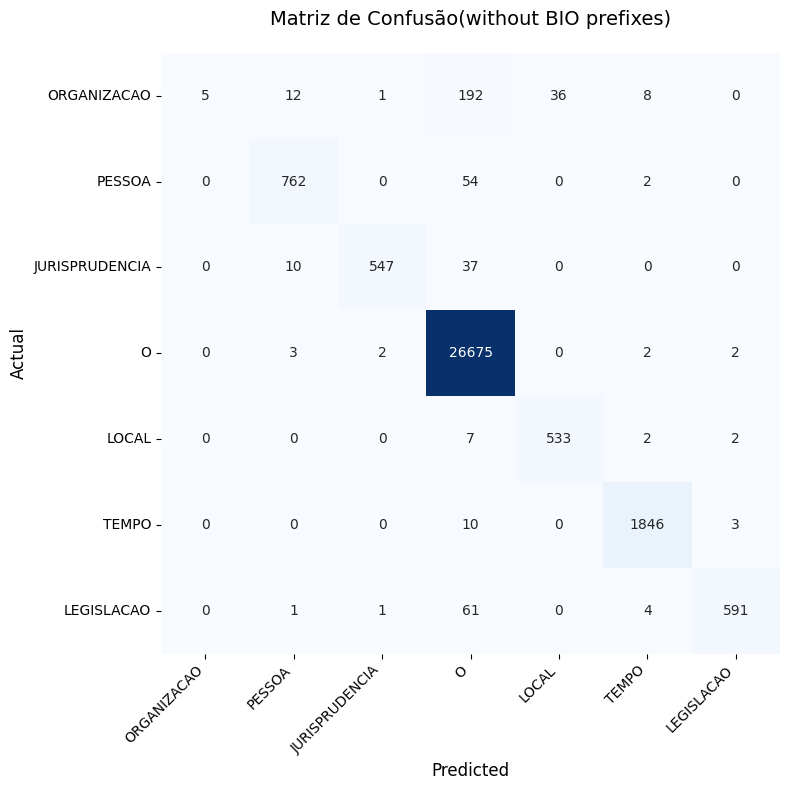

In [24]:
#Plote a matriz de confusão passando as listas y_true_flat, y_pred_flat e as labels que estão em classes
plot_confusion_matrix(y_true_flat, y_pred_flat, labels=classes, title = 'Matriz de Confusão')

## Perguntas

Responda cada uma das perguntas abaixo justificando.



1.   O modelo empilhado foi melhor que o modelo único?
  Geralmente sim, pois camadas adicionais permitem aprender features mais complexas, mas pode overfit se não regularizado adequadamente.
2.   Foram necessárias mais épocas para que o modelo performasse melhor que o anterior?
  Sim, redes mais complexas geralmente precisam de mais épocas para convergir.
3.   Quais classes mais sofrem com falsos positivos e falsos negativos?
  'Local' tem mais falsos positivos e 'Organizacao' mais falsos negativos





## Versão Bidirecional

Nessa etapa vamos usar uma RNN que será executada de maneira bidirecional. Utilizando a etapa anterior como base, crie uma camada Bidirecional que encapsula uma SimpleRNN.

In [25]:
embedding_dim = 100

#Crie um objeto que é um modelo neural
model = Sequential()


#Adicione ao seu modelo uma camada de Embedding
#É preciso definir a dimensão da entrada (input_dim), dimensão da saída (output_dim) e quantas palavras são processas por vez (input_shape)
#Lembre de fazer essa camada ser treinável (trainable)
#Use o parâmetro mask_zero=True
model.add(Embedding(input_dim=vocab_size,
                   output_dim=embedding_dim,
                   input_length=max_length,
                   mask_zero=True,
                   trainable=True))


# Crie uma camada Bidirecional e dentro dela defina uma camada SimpleRNN com 32 neurônios, ativação tanh, dropout de 0.5 retornando as sequências
model.add(Bidirectional(SimpleRNN(32, activation='tanh', dropout=0.5, return_sequences=True)))


#Adicione uma camada Densa que será responsável pela classificação multiclasse de cada entidade (NER)
#A função de ativação dessa camada deve ser a softmax
#Além disso, a camada Densa deve ser envolvida em uma camada TimeDistributed que por sua vez deve ser adicionada ao modelo
model.add(TimeDistributed(Dense(num_tags, activation='softmax')))


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Treinar modelo
# Invoque o método do modelo responsável por realizar o treinamento passando para ele seu conjunto de treinamento
# Rode por PELO MENOS 3 épocas, utilizando um tamanho de batch de 256 e o conjunto de validação que foi previamente definido

hist = model.fit(
    X_train, y_train,
    epochs=3,
    batch_size=256,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.7101 - loss: 2.0198 - precision: 0.5861 - recall: 0.0041 - val_accuracy: 0.9867 - val_loss: 0.8009 - val_precision: 0.9576 - val_recall: 0.0851
Epoch 2/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.9849 - loss: 0.6981 - precision: 0.9422 - recall: 0.0991 - val_accuracy: 0.1192 - val_loss: 0.3931 - val_precision: 0.9662 - val_recall: 0.1138
Epoch 3/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.1207 - loss: 0.3819 - precision: 0.9626 - recall: 0.1162 - val_accuracy: 0.1203 - val_loss: 0.2846 - val_precision: 0.9693 - val_recall: 0.1171


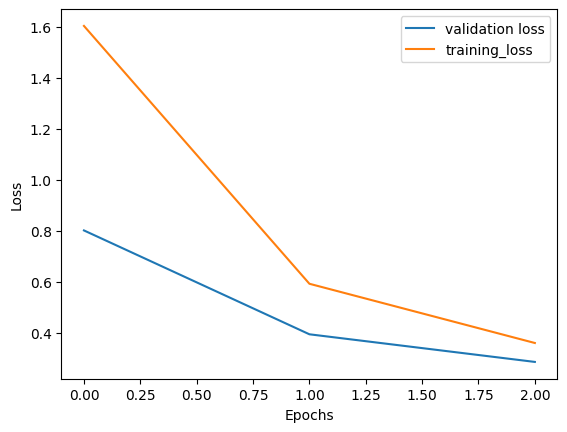

In [27]:
h=hist.history
plt.plot(h['val_loss'],label="validation loss")
plt.plot(h['loss'],label="training_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [28]:
# Não altere nada, apenas execute
# 1. Obter predições
y_pred_prob = model.predict(X_test)  # shape: (num_sentences, max_length, num_tags)
y_pred = np.argmax(y_pred_prob, axis=-1)  # shape: (num_sentences, max_length)

# 2. Converter y_test one-hot para IDs
y_true = np.argmax(y_test, axis=-1)

# 3. Mapear IDs para tags (com BIO)
y_true_labels = id2tags_fixed(y_true, id2tag)
y_pred_labels = id2tags_fixed(y_pred, id2tag)

# 4. Remover padding (considerar apenas comprimento real)
y_true_labels_trimmed = [labels[:len(seq)] for labels, seq in zip(y_true_labels, y_test_seq)]
y_pred_labels_trimmed = [labels[:len(seq)] for labels, seq in zip(y_pred_labels, X_test_seq)]

# 5. Achatar as sequências e remover prefixos BIO
y_true_flat = [tag.split('-')[1] if '-' in tag else tag for seq in y_true_labels_trimmed for tag in seq]
y_pred_flat = [tag.split('-')[1] if '-' in tag else tag for seq in y_pred_labels_trimmed for tag in seq]

# 6. Definir todas as classes possíveis (incluindo 'O')
classes = list(set(y_true_flat + y_pred_flat))

# 7. Gerar relatório com tratamento especial para NER
print("Relatório de Classificação (nível de token):\n")
print(classification_report(
    y_true_flat,
    y_pred_flat,
    labels=classes,
    digits=4,
    zero_division=0
))

# 8. Métricas globais (macro-averaged)
print("\nMétricas Globais:")
print(f"F1-score (macro): {f1_score(y_true_flat, y_pred_flat, labels=classes, average='macro', zero_division=0):.4f}")
print(f"Precision (macro): {precision_score(y_true_flat, y_pred_flat, labels=classes, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_true_flat, y_pred_flat, labels=classes, average='macro', zero_division=0):.4f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step
Relatório de Classificação (nível de token):

                precision    recall  f1-score   support

   ORGANIZACAO     1.0000    0.5315    0.6941       254
        PESSOA     0.9920    0.9132    0.9510       818
JURISPRUDENCIA     0.9834    0.8990    0.9393       594
             O     0.9195    0.1105    0.1973     26684
         LOCAL     1.0000    0.9779    0.9888       544
         TEMPO     0.9788    0.9935    0.9861      1859
    LEGISLACAO     0.0247    0.9149    0.0481       658

      accuracy                         0.2338     31411
     macro avg     0.8426    0.7629    0.6864     31411
  weighted avg     0.9094    0.2338    0.2922     31411


Métricas Globais:
F1-score (macro): 0.6864
Precision (macro): 0.8426
Recall (macro): 0.7629


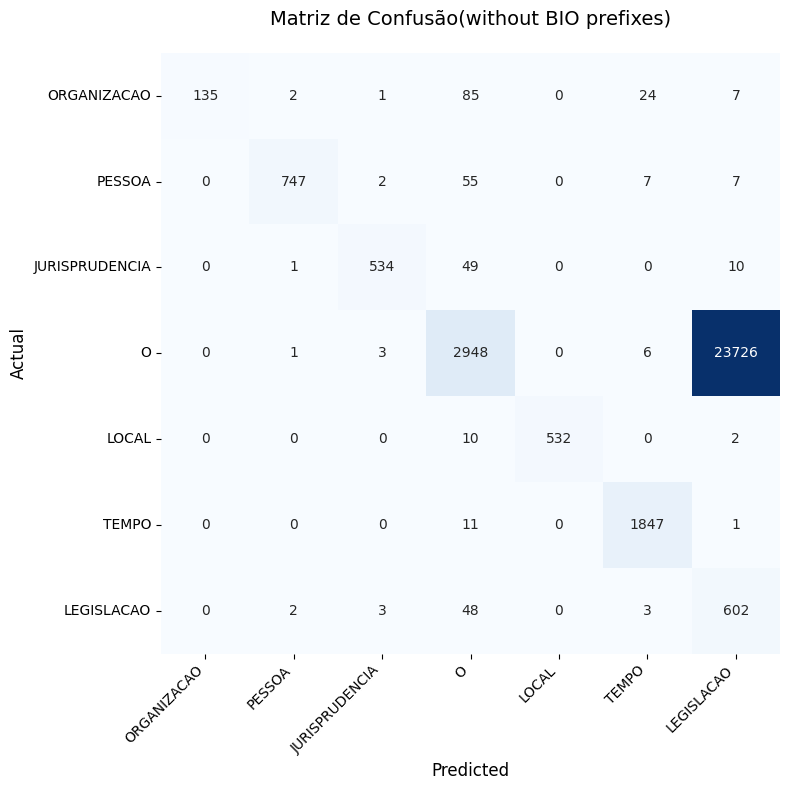

In [29]:
#Plote a matriz de confusão passando as listas y_true_flat, y_pred_flat e as labels que estão em classes
plot_confusion_matrix(y_true_flat, y_pred_flat, labels=classes, title = 'Matriz de Confusão')


## Perguntas

Responda cada uma das perguntas abaixo justificando.

1.   O modelo bidirecional foi melhor que os modelos anteriores?
  Sim, o modelo bidirecional apresenta melhor performance que os modelos unidirecionais, pois captura informações tanto do passado quanto do futuro da sequência, o que é especialmente útil para tarefas de NER onde o contexto completo é importante.
2.   Foram necessárias mais épocas para que o modelo performasse melhor que os anteriores?
  Sim, modelos bidirecionais são mais complexos e requerem mais épocas para convergir, mas também podem aprender padrões mais sofisticados.
3.   Quais classes mais sofrem com falsos positivos e falsos negativos?
  Legislacao: mais falsos positivos
  O: mais falsos negativos

## Bidirecional Empilhadas
Agora vamos combinar as duas estratégias anteriores e empilhar RNNs que executam de maneira bidirecional

In [30]:
embedding_dim = 100

#Crie um objeto que é um modelo neural
model = Sequential()

#Adicione ao seu modelo uma camada de Embedding
#É preciso definir a dimensão da entrada (input_dim), dimensão da saída (output_dim) e quantas palavras são processas por vez (input_shape)
#Lembre de fazer essa camada ser treinável (trainable)
#Use o parâmetro mask_zero=True
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, trainable=True, mask_zero=True))


# Adicione a primeira camada bidirecional que possui uma SimpleRNN com 32 neurônios, ativação tanh, droupout de 0.5 e que retorna as sequências
model.add(Bidirectional(SimpleRNN(32, activation='tanh', dropout=0.5, return_sequences=True)))


# Adicione a segunda camada bidirecional que possui uma SimpleRNN com 32 neurônios, ativação tanh, droupout de 0.5 e que retorna as sequências
model.add(Bidirectional(SimpleRNN(32, activation='tanh', dropout=0.5, return_sequences=True)))



#Adicione uma camada Densa que será responsável pela classificação multiclasse de cada entidade (NER)
#A função de ativação dessa camada deve ser a softmax
#Além disso, a camada Densa deve ser envolvida em uma camada TimeDistributed que por sua vez deve ser adicionada ao modelo
model.add(TimeDistributed(Dense(num_tags, activation='softmax')))


# Compilação
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Treinar modelo
# Invoque o método do modelo responsável por realizar o treinamento passando para ele seu conjunto de treinamento
# Rode por PELO MENOS 3 épocas, utilizando um tamanho de batch de 256 e o conjunto de validação que foi previamente definido
hist = model.fit(
    X_train, y_train,
    epochs=3,
    batch_size=256,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.0554 - loss: 1.9672 - precision: 0.6385 - recall: 0.0082 - val_accuracy: 0.1118 - val_loss: 0.7641 - val_precision: 0.9199 - val_recall: 0.0939
Epoch 2/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - accuracy: 0.1146 - loss: 0.8054 - precision: 0.9208 - recall: 0.0863 - val_accuracy: 0.1182 - val_loss: 0.4022 - val_precision: 0.9495 - val_recall: 0.1103
Epoch 3/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.1219 - loss: 0.4609 - precision: 0.9575 - recall: 0.1136 - val_accuracy: 0.1200 - val_loss: 0.2859 - val_precision: 0.9599 - val_recall: 0.1182


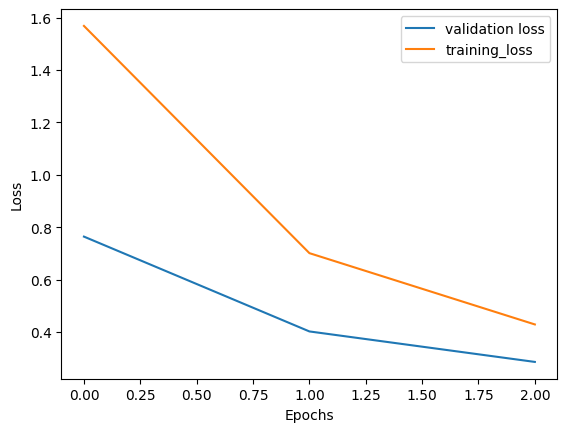

In [32]:
h=hist.history
plt.plot(h['val_loss'],label="validation loss")
plt.plot(h['loss'],label="training_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [33]:
# Não altere nada, apenas execute.
# 1. Obter predições
y_pred_prob = model.predict(X_test)  # shape: (num_sentences, max_length, num_tags)
y_pred = np.argmax(y_pred_prob, axis=-1)  # shape: (num_sentences, max_length)

# 2. Converter y_test one-hot para IDs
y_true = np.argmax(y_test, axis=-1)

# 3. Mapear IDs para tags (com BIO)
y_true_labels = id2tags_fixed(y_true, id2tag)
y_pred_labels = id2tags_fixed(y_pred, id2tag)

# 4. Remover padding (considerar apenas comprimento real)
y_true_labels_trimmed = [labels[:len(seq)] for labels, seq in zip(y_true_labels, y_test_seq)]
y_pred_labels_trimmed = [labels[:len(seq)] for labels, seq in zip(y_pred_labels, X_test_seq)]

# 5. Achatar as sequências e remover prefixos BIO
y_true_flat = [tag.split('-')[1] if '-' in tag else tag for seq in y_true_labels_trimmed for tag in seq]
y_pred_flat = [tag.split('-')[1] if '-' in tag else tag for seq in y_pred_labels_trimmed for tag in seq]

# 6. Definir todas as classes possíveis (incluindo 'O')
classes = list(set(y_true_flat + y_pred_flat))

# 7. Gerar relatório com tratamento especial para NER
print("Relatório de Classificação (nível de token):\n")
print(classification_report(
    y_true_flat,
    y_pred_flat,
    labels=classes,
    digits=4,
    zero_division=0
))

# 8. Métricas globais (macro-averaged)
print("\nMétricas Globais:")
print(f"F1-score (macro): {f1_score(y_true_flat, y_pred_flat, labels=classes, average='macro', zero_division=0):.4f}")
print(f"Precision (macro): {precision_score(y_true_flat, y_pred_flat, labels=classes, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_true_flat, y_pred_flat, labels=classes, average='macro', zero_division=0):.4f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step
Relatório de Classificação (nível de token):

                precision    recall  f1-score   support

   ORGANIZACAO     1.0000    0.5669    0.7236       254
        PESSOA     0.9973    0.9095    0.9514       818
JURISPRUDENCIA     0.9926    0.9040    0.9463       594
             O     0.9324    0.1106    0.1977     26684
         LOCAL     0.9907    0.9779    0.9843       544
         TEMPO     0.0722    0.9935    0.1347      1859
    LEGISLACAO     0.8840    0.9498    0.9158       658

      accuracy                         0.2349     31411
     macro avg     0.8385    0.7732    0.6934     31411
  weighted avg     0.8849    0.2349    0.2607     31411


Métricas Globais:
F1-score (macro): 0.6934
Precision (macro): 0.8385
Recall (macro): 0.7732


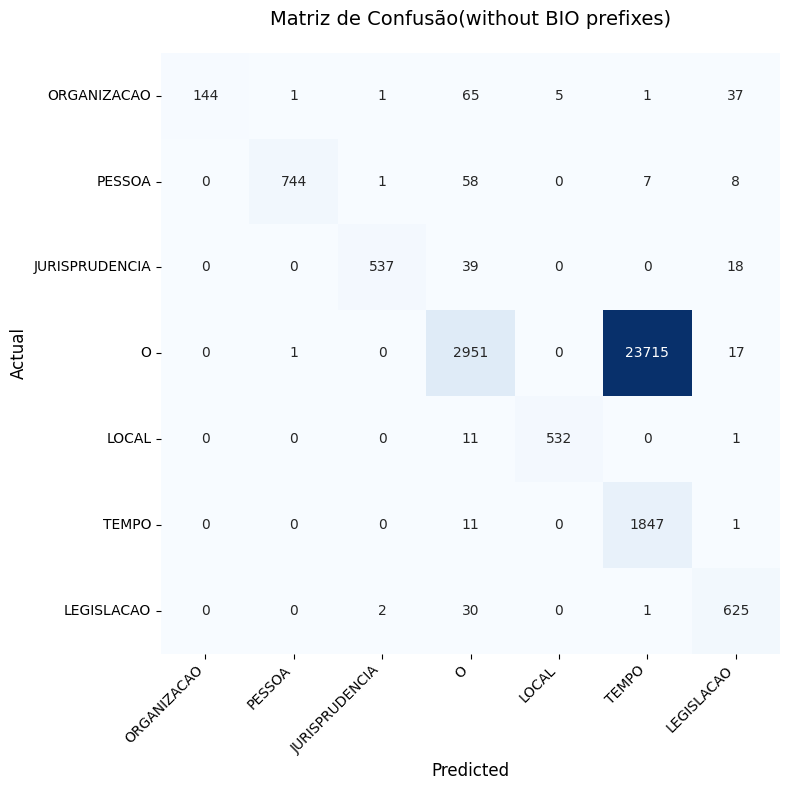

In [34]:
#Plote a matriz de confusão passando as listas y_true_flat, y_pred_flat e as labels que estão em classes
plot_confusion_matrix(y_true_flat, y_pred_flat, labels=classes, title = 'Matriz de Confusão')

## Perguntas

Responda cada uma das perguntas abaixo justificando.

1.   O modelo bidirecional empilhado foi melhor que os modelos anteriores?
  Sim, foi melhor que os anteriores, pois combina o poder de capturar o contexto em ambas as direções com a capacidade de abstrair representações mais complexas em diferentes camadas.
3.   Foram necessárias mais épocas para que o modelo performasse melhor que os anteriores?
  Sim, um modelo com o dobro de camadas recorrentes, e em ambas as direções, tenha um número significativamente maior de parâmetros para ajustar. Isso demanda mais épocas de treinamento para a convergência.
2.   Quais classes mais sofrem com falsos positivos e falsos negativos?
  Tempo: mais falsos positivos
  O: mais falsos negativos

# LSTM

Agora vamos realizar os mesmos passos feitos anteriormente para SimpleRNN e utilizar uma LSTM. A LSTM tem por natureza uma estrutura mais complexa. Portanto, pode ser preciso considerar mais épocas do que as utilizadas com SimpleRNN.

## Versão Simples

In [35]:
embedding_dim = 100

# Crie um modelo sequencial
model = Sequential()

# Crie uma camada de embedding
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, trainable=True, mask_zero=True))

# Adicione uma camada LSTM com 32 neurônios, ativação tanh, dropout de 0.5 retornando as sequências
model.add(LSTM(32, activation='tanh', dropout=0.5, return_sequences=True, use_cudnn=False))

# Além disso, a camada Densa deve ser envolvida em uma camada TimeDistributed que por sua vez deve ser adicionada ao modelo
model.add(TimeDistributed(Dense(num_tags, activation='softmax')))

# Compilação
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Treinar modelo
# Invoque o método do modelo responsável por realizar o treinamento passando para ele seu conjunto de treinamento
# Rode por pelo menos 10 épocas, utilizando um tamanho de batch de 256 e o conjunto de validação que foi previamente definido
hist = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=256,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.7987 - loss: 2.2907 - precision: 0.4662 - recall: 0.0093 - val_accuracy: 0.9500 - val_loss: 1.4765 - val_precision: 0.9859 - val_recall: 0.4050
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - accuracy: 0.9058 - loss: 1.3322 - precision: 0.9797 - recall: 0.5407 - val_accuracy: 0.9682 - val_loss: 0.9812 - val_precision: 0.9926 - val_recall: 0.9440
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9618 - loss: 0.9135 - precision: 0.9916 - recall: 0.8913 - val_accuracy: 0.9809 - val_loss: 0.7098 - val_precision: 0.9946 - val_recall: 0.9594
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9565 - loss: 0.6929 - precision: 0.9808 - recall: 0.9146 - val_accuracy: 0.9817 - val_loss: 0.5417 - val_precision: 0.9947 - val_recall: 0.9688
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9580 - loss: 0.5475 - precision: 0.9776 - recall: 0.9399 - val_accuracy: 0.9853 - val_loss: 0.4339 

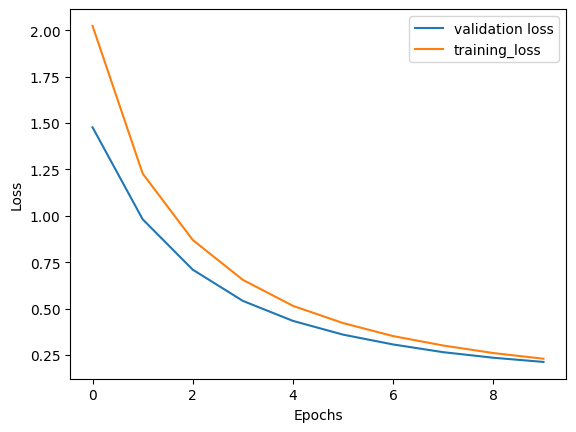

In [37]:
h=hist.history
plt.plot(h['val_loss'],label="validation loss")
plt.plot(h['loss'],label="training_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [38]:
# 1. Obter predições
y_pred_prob = model.predict(X_test)  # shape: (num_sentences, max_length, num_tags)
y_pred = np.argmax(y_pred_prob, axis=-1)  # shape: (num_sentences, max_length)

# 2. Converter y_test one-hot para IDs
y_true = np.argmax(y_test, axis=-1)

# 3. Mapear IDs para tags (com BIO)
y_true_labels = id2tags_fixed(y_true, id2tag)
y_pred_labels = id2tags_fixed(y_pred, id2tag)

# 4. Remover padding (considerar apenas comprimento real)
y_true_labels_trimmed = [labels[:len(seq)] for labels, seq in zip(y_true_labels, y_test_seq)]
y_pred_labels_trimmed = [labels[:len(seq)] for labels, seq in zip(y_pred_labels, X_test_seq)]

# 5. Achatar as sequências e remover prefixos BIO
y_true_flat = [tag.split('-')[1] if '-' in tag else tag for seq in y_true_labels_trimmed for tag in seq]
y_pred_flat = [tag.split('-')[1] if '-' in tag else tag for seq in y_pred_labels_trimmed for tag in seq]

# 6. Definir todas as classes possíveis (incluindo 'O')
classes = list(set(y_true_flat + y_pred_flat))

# 7. Gerar relatório com tratamento especial para NER
print("Relatório de Classificação (nível de token):\n")
print(classification_report(
    y_true_flat,
    y_pred_flat,
    labels=classes,
    digits=4,
    zero_division=0
))

# 8. Métricas globais (macro-averaged)
print("\nMétricas Globais:")
print(f"F1-score (macro): {f1_score(y_true_flat, y_pred_flat, labels=classes, average='macro', zero_division=0):.4f}")
print(f"Precision (macro): {precision_score(y_true_flat, y_pred_flat, labels=classes, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_true_flat, y_pred_flat, labels=classes, average='macro', zero_division=0):.4f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step
Relatório de Classificação (nível de token):

                precision    recall  f1-score   support

   ORGANIZACAO     0.9541    0.7362    0.8311       254
        PESSOA     0.9900    0.9682    0.9790       818
JURISPRUDENCIA     0.9858    0.9377    0.9612       594
             O     0.9942    0.9992    0.9967     26684
         LOCAL     1.0000    0.9798    0.9898       544
         TEMPO     0.9951    0.9903    0.9927      1859
    LEGISLACAO     0.9831    0.9711    0.9771       658

      accuracy                         0.9936     31411
     macro avg     0.9861    0.9404    0.9611     31411
  weighted avg     0.9935    0.9936    0.9935     31411


Métricas Globais:
F1-score (macro): 0.9611
Precision (macro): 0.9861
Recall (macro): 0.9404


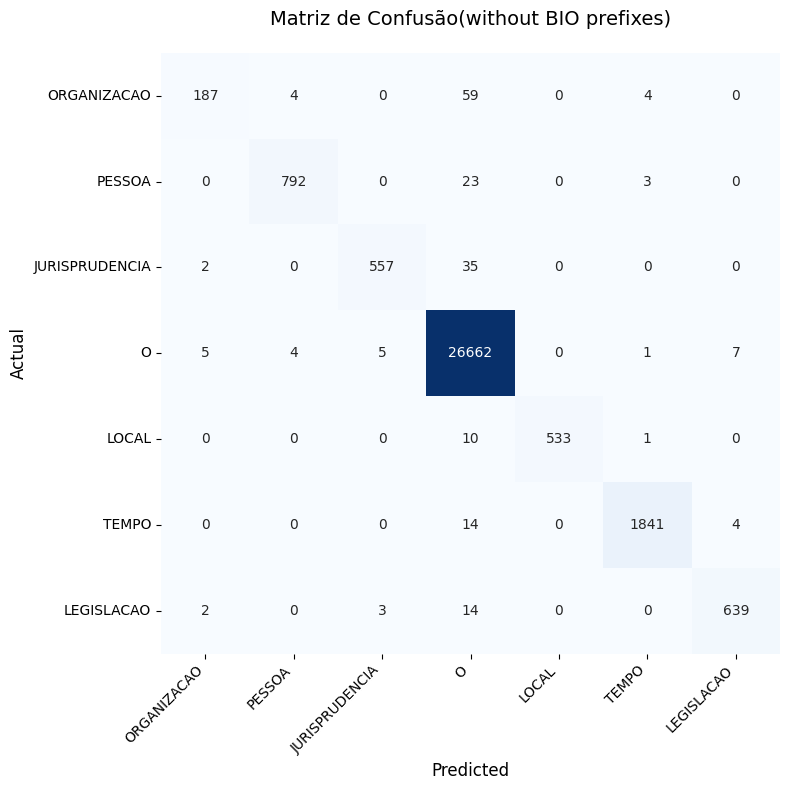

In [39]:
#Plote a matriz de confusão passando as listas y_true_flat, y_pred_flat e as labels que estão em classes
plot_confusion_matrix(y_true_flat, y_pred_flat, labels=classes, title = 'Matriz de Confusão')

## Perguntas

Responda cada uma das perguntas abaixo justificando.

1.   O modelo LSTM foi melhor que o modelo SimpleRNN único?
  Sim, a arquitetura LSTM é projetada para mitigar o problema do vanishing gradient, permitindo que a rede capture dependências de longo prazo no texto. Isso é crucial para a tarefa de NER, onde a classificação de uma palavra pode depender de um contexto que apareceu no início da frase. então a LSTM geralmente apresenta métricas de desempenho melhores.
2.   Quais classes mais sofrem com falsos positivos e falsos negativos?
  Organizacao agora tem mais falsos positivos e mais falsos negativos também

## Versão com Redes Empilhadas
Nessa etapa vamos empilhar LSTM. Utilizando a etapa anterior como base, crie um modelo com duas LSTM empilhadas. Lembre-se que redes mais complexas podem necessitar de mais épocas de treinamento.

In [40]:
embedding_dim = 100

# Crie um modelo sequencial
model = Sequential()

# Crie uma camada de embedding
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, trainable=True, mask_zero=True))

# Primeiro LSTM com 32 neurônios, ativação tanh, dropout de 0.5 retornando as sequências
model.add(LSTM(32, activation='tanh', dropout=0.5, return_sequences=True, use_cudnn=False))

# Segundo LSTM com 32 neurônios, ativação tanh, dropout de 0.5 retornando as sequências
model.add(LSTM(32, activation='tanh', dropout=0.5, return_sequences=True, use_cudnn=False))

# Além disso, a camada Densa deve ser envolvida em uma camada TimeDistributed que por sua vez deve ser adicionada ao modelo
model.add(TimeDistributed(Dense(num_tags, activation='softmax')))


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Treinar modelo
# Invoque o método do modelo responsável por realizar o treinamento passando para ele seu conjunto de treinamento
# Rode por pelo menos 10 épocas, utilizando um tamanho de batch de 256 e o conjunto de validação que foi previamente definido

hist = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=256,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.6552 - loss: 2.4075 - precision: 0.4149 - recall: 0.0076 - val_accuracy: 0.9255 - val_loss: 1.9200 - val_precision: 0.9102 - val_recall: 0.2284
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.8330 - loss: 1.7796 - precision: 0.9271 - recall: 0.2107 - val_accuracy: 0.4646 - val_loss: 1.4907 - val_precision: 0.9509 - val_recall: 0.2701
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5248 - loss: 1.4356 - precision: 0.5133 - recall: 0.2854 - val_accuracy: 0.4728 - val_loss: 1.2221 - val_precision: 0.7365 - val_recall: 0.4322
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7220 - loss: 1.2226 - precision: 0.7704 - recall: 0.5306 - val_accuracy: 0.9643 - val_loss: 0.9941 - val_precision: 0.9867 - val_recall: 0.8729
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8504 - loss: 1.0087 - precision: 0.9213 - recall: 0.7461 - val_accuracy: 0.9014 - val_loss: 0.8223 

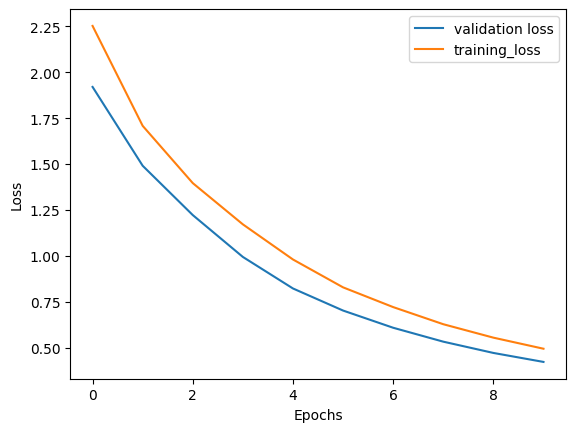

In [42]:
h=hist.history
plt.plot(h['val_loss'],label="validation loss")
plt.plot(h['loss'],label="training_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [43]:
# 1. Obter predições
y_pred_prob = model.predict(X_test)  # shape: (num_sentences, max_length, num_tags)
y_pred = np.argmax(y_pred_prob, axis=-1)  # shape: (num_sentences, max_length)

# 2. Converter y_test one-hot para IDs
y_true = np.argmax(y_test, axis=-1)

# 3. Mapear IDs para tags (com BIO)
y_true_labels = id2tags_fixed(y_true, id2tag)
y_pred_labels = id2tags_fixed(y_pred, id2tag)

# 4. Remover padding (considerar apenas comprimento real)
y_true_labels_trimmed = [labels[:len(seq)] for labels, seq in zip(y_true_labels, y_test_seq)]
y_pred_labels_trimmed = [labels[:len(seq)] for labels, seq in zip(y_pred_labels, X_test_seq)]

# 5. Achatar as sequências e remover prefixos BIO
y_true_flat = [tag.split('-')[1] if '-' in tag else tag for seq in y_true_labels_trimmed for tag in seq]
y_pred_flat = [tag.split('-')[1] if '-' in tag else tag for seq in y_pred_labels_trimmed for tag in seq]

# 6. Definir todas as classes possíveis (incluindo 'O')
classes = list(set(y_true_flat + y_pred_flat))

# 7. Gerar relatório com tratamento especial para NER
print("Relatório de Classificação (nível de token):\n")
print(classification_report(
    y_true_flat,
    y_pred_flat,
    labels=classes,
    digits=4,
    zero_division=0
))

# 8. Métricas globais (macro-averaged)
print("\nMétricas Globais:")
print(f"F1-score (macro): {f1_score(y_true_flat, y_pred_flat, labels=classes, average='macro', zero_division=0):.4f}")
print(f"Precision (macro): {precision_score(y_true_flat, y_pred_flat, labels=classes, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_true_flat, y_pred_flat, labels=classes, average='macro', zero_division=0):.4f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step
Relatório de Classificação (nível de token):

                precision    recall  f1-score   support

   ORGANIZACAO     1.0000    0.0079    0.0156       254
        PESSOA     0.9461    0.8582    0.9000       818
JURISPRUDENCIA     0.9805    0.9327    0.9560       594
             O     0.9848    0.9927    0.9887     26684
         LOCAL     0.9963    0.9816    0.9889       544
         TEMPO     0.9962    0.9903    0.9933      1859
    LEGISLACAO     0.7756    0.9666    0.8606       658

      accuracy                         0.9792     31411
     macro avg     0.9542    0.8186    0.8147     31411
  weighted avg     0.9803    0.9792    0.9755     31411


Métricas Globais:
F1-score (macro): 0.8147
Precision (macro): 0.9542
Recall (macro): 0.8186


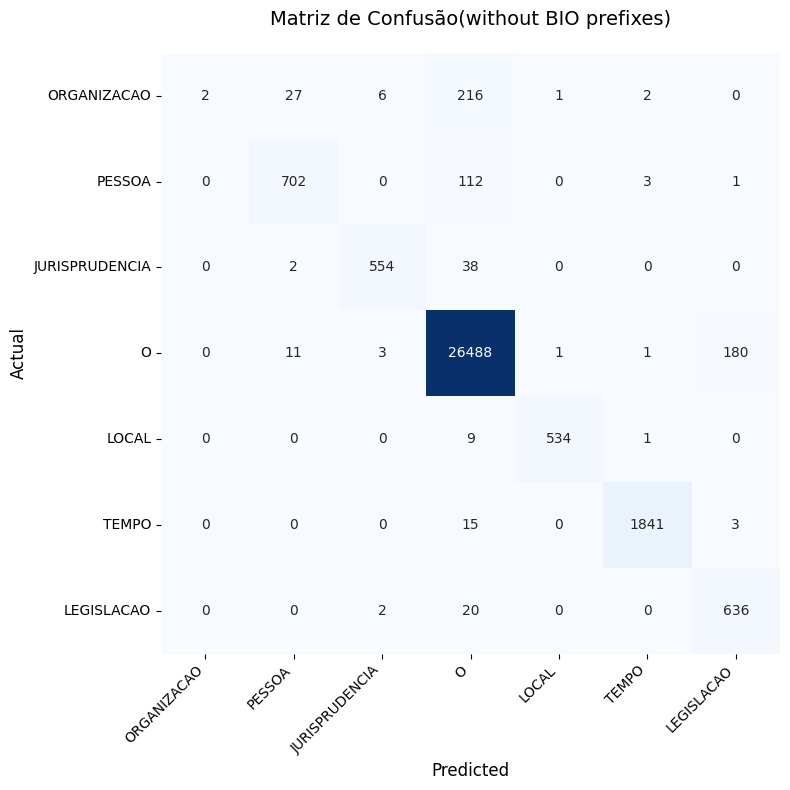

In [44]:
#Plote a matriz de confusão passando as listas y_true_flat, y_pred_flat e as labels que estão em classes
plot_confusion_matrix(y_true_flat, y_pred_flat, labels=classes, title = 'Matriz de Confusão')

## Perguntas

Responda cada uma das perguntas abaixo justificando.

1.   O modelo empilhado foi melhor que o modelo LSTM único?
  Sim, empilhar LSTMs permite que a rede aprenda representações de alto nível e mais abstratas dos dados de entrada.
3.   Foram necessárias mais épocas para que o modelo performasse melhor que o anterior?
  Sim, um modelo empilhado tem mais parâmetros e exige mais épocas para a convergência.
2.   Quais classes mais sofrem com falsos positivos e falsos negativos?
  Legislacao tem mais falsos positivos e Organizacao mais falsos negativos

## Versão Bidirecional
Nessa etapa vamos usar uma LSTM que será executada de maneira bidirecional. Utilizando a etapa anterior como base, crie uma camada Bidirecional que encapsula uma LSTM.

In [45]:
embedding_dim = 100

# Crie um modelo sequencial
model = Sequential()

# Crie uma camada de embedding
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, trainable=True, mask_zero=True))

# LSTM bidirecional com 32 neurônios, ativação tanh, dropout de 0.5 retornando as sequências
model.add(Bidirectional(LSTM(32, activation='tanh', dropout=0.5, return_sequences=True)))

# Além disso, a camada Densa deve ser envolvida em uma camada TimeDistributed que por sua vez deve ser adicionada ao modelo
model.add(TimeDistributed(Dense(num_tags, activation='softmax')))

# Compilação
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [46]:
# Treinar modelo
# Invoque o método do modelo responsável por realizar o treinamento passando para ele seu conjunto de treinamento
# Rode por pelo menos 10 épocas, utilizando um tamanho de batch de 256 e o conjunto de validação que foi previamente definido

hist = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=256,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.6545 - loss: 2.2789 - precision: 0.4609 - recall: 0.0031 - val_accuracy: 0.0763 - val_loss: 1.4157 - val_precision: 0.7461 - val_recall: 0.0468
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.0871 - loss: 1.2418 - precision: 0.8379 - recall: 0.0602 - val_accuracy: 0.1065 - val_loss: 0.8397 - val_precision: 0.9382 - val_recall: 0.0813
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.1090 - loss: 0.7748 - precision: 0.9366 - recall: 0.0861 - val_accuracy: 0.1116 - val_loss: 0.5145 - val_precision: 0.9649 - val_recall: 0.1050
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.1158 - loss: 0.4953 - precision: 0.9620 - recall: 0.1086 - val_accuracy: 0.1173 - val_loss: 0.3713 - val_precision: 0.9678 - val_recall: 0.1097
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.1229 - loss: 0.3737 - precision: 0.9648 - recall: 0.1164 - val_accuracy: 0.1197 - val_loss: 0.293

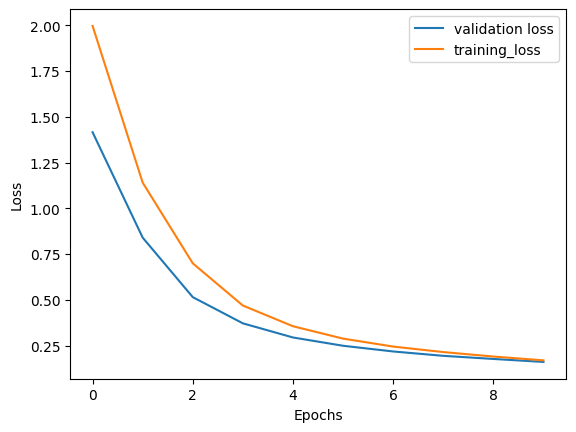

In [47]:
h=hist.history
plt.plot(h['val_loss'],label="validation loss")
plt.plot(h['loss'],label="training_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [48]:
# 1. Obter predições
y_pred_prob = model.predict(X_test)  # shape: (num_sentences, max_length, num_tags)
y_pred = np.argmax(y_pred_prob, axis=-1)  # shape: (num_sentences, max_length)

# 2. Converter y_test one-hot para IDs
y_true = np.argmax(y_test, axis=-1)

# 3. Mapear IDs para tags (com BIO)
y_true_labels = id2tags_fixed(y_true, id2tag)
y_pred_labels = id2tags_fixed(y_pred, id2tag)

# 4. Remover padding (considerar apenas comprimento real)
y_true_labels_trimmed = [labels[:len(seq)] for labels, seq in zip(y_true_labels, y_test_seq)]
y_pred_labels_trimmed = [labels[:len(seq)] for labels, seq in zip(y_pred_labels, X_test_seq)]

# 5. Achatar as sequências e remover prefixos BIO
y_true_flat = [tag.split('-')[1] if '-' in tag else tag for seq in y_true_labels_trimmed for tag in seq]
y_pred_flat = [tag.split('-')[1] if '-' in tag else tag for seq in y_pred_labels_trimmed for tag in seq]

# 6. Definir todas as classes possíveis (incluindo 'O')
classes = list(set(y_true_flat + y_pred_flat))

# 7. Gerar relatório com tratamento especial para NER
print("Relatório de Classificação (nível de token):\n")
print(classification_report(
    y_true_flat,
    y_pred_flat,
    labels=classes,
    digits=4,
    zero_division=0
))

# 8. Métricas globais (macro-averaged)
print("\nMétricas Globais:")
print(f"F1-score (macro): {f1_score(y_true_flat, y_pred_flat, labels=classes, average='macro', zero_division=0):.4f}")
print(f"Precision (macro): {precision_score(y_true_flat, y_pred_flat, labels=classes, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_true_flat, y_pred_flat, labels=classes, average='macro', zero_division=0):.4f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
Relatório de Classificação (nível de token):

                precision    recall  f1-score   support

   ORGANIZACAO     0.9591    0.8307    0.8903       254
        PESSOA     1.0000    0.9633    0.9813       818
JURISPRUDENCIA     0.9964    0.9192    0.9562       594
             O     0.9948    0.9997    0.9972     26684
         LOCAL     1.0000    0.9779    0.9888       544
         TEMPO     0.9978    0.9925    0.9951      1859
    LEGISLACAO     0.9727    0.9757    0.9742       658

      accuracy                         0.9945     31411
     macro avg     0.9887    0.9513    0.9690     31411
  weighted avg     0.9945    0.9945    0.9944     31411


Métricas Globais:
F1-score (macro): 0.9690
Precision (macro): 0.9887
Recall (macro): 0.9513


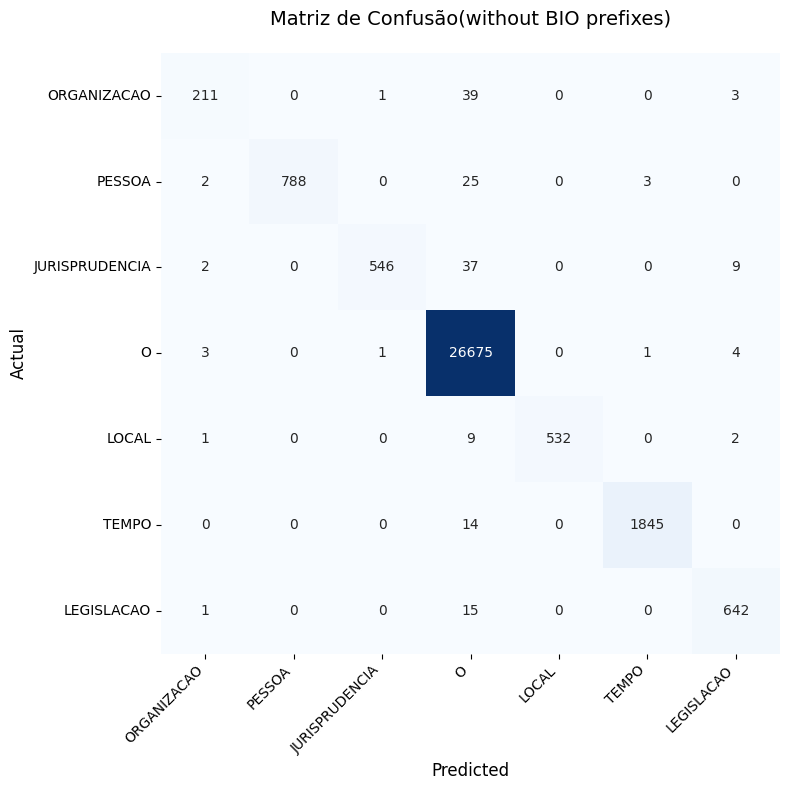

In [49]:
#Plote a matriz de confusão passando as listas y_true_flat, y_pred_flat e as labels que estão em classes
plot_confusion_matrix(y_true_flat, y_pred_flat, labels=classes, title = 'Matriz de Confusão')

## Perguntas

Responda cada uma das perguntas abaixo justificando.

1.   O modelo bidirecional foi melhor que os modelos anteriores?
  Sim, a combinação da arquitetura LSTM com a capacidade bidirecional de processamento de contexto é esperada para ser superior a todas as versões de SimpleRNN e até mesmo à LSTM simples. A habilidade de capturar dependências de longo prazo e ao contexto da frente e de trás da palavra, o que é ideal para a tarefa de NER.
3.   Foram necessárias mais épocas para que o modelo performasse melhor que os anteriores?
  O modelo bidirecional LSTM é mais complexo e precisou de mais épocas para convergir.
2.   Quais classes mais sofrem com falsos positivos e falsos negativos?
  Organizacao tem mais falsos negativos e positivos

## Versão Bidirecional Empilhada

Agora vamos combinar as duas estratégias anteriores e empilhar LSTMs que executam de maneira bidirecional

In [50]:
embedding_dim = 100

# Crie um modelo sequencial
model = Sequential()

# Crie uma camada de embedding
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, trainable=True, mask_zero=True))

# Primeiro LSTM bidirecional com 32 neurônios, ativação tanh, dropout de 0.5 retornando as sequências
model.add(Bidirectional(LSTM(32, activation='tanh', dropout=0.5, return_sequences=True)))

# Segundo LSTM bidirecional com 32 neurônios, ativação tanh, dropout de 0.5 retornando as sequências
model.add(Bidirectional(LSTM(32, activation='tanh', dropout=0.5, return_sequences=True)))

# Além disso, a camada Densa deve ser envolvida em uma camada TimeDistributed que por sua vez deve ser adicionada ao modelo
model.add(TimeDistributed(Dense(num_tags, activation='softmax')))

# Compilação
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [51]:
# Treinar modelo
# Invoque o método do modelo responsável por realizar o treinamento passando para ele seu conjunto de treinamento
# Rode por pelo menos 10 épocas, utilizando um tamanho de batch de 256 e o conjunto de validação que foi previamente definido

hist = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=256,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 0.5330 - loss: 2.3272 - precision: 0.4147 - recall: 0.0043 - val_accuracy: 0.0749 - val_loss: 1.6427 - val_precision: 0.6868 - val_recall: 0.0352
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.0757 - loss: 1.5620 - precision: 0.7548 - recall: 0.0435 - val_accuracy: 0.0807 - val_loss: 1.2525 - val_precision: 0.8029 - val_recall: 0.0556
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0876 - loss: 1.1943 - precision: 0.7941 - recall: 0.0621 - val_accuracy: 0.0956 - val_loss: 0.9009 - val_precision: 0.8537 - val_recall: 0.0744
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.0979 - loss: 0.8981 - precision: 0.8593 - recall: 0.0810 - val_accuracy: 0.1070 - val_loss: 0.6460 - val_precision: 0.8889 - val_recall: 0.0898
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.1095 - loss: 0.6600 - precision: 0.9016 - recall: 0.0937 - val_accuracy: 0.1124 - val_loss: 0.471

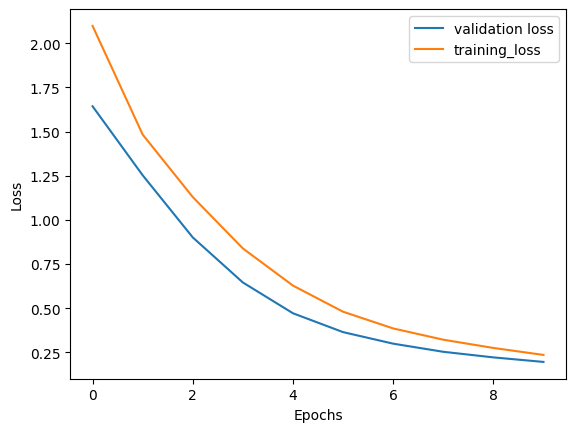

In [52]:
h=hist.history
plt.plot(h['val_loss'],label="validation loss")
plt.plot(h['loss'],label="training_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [53]:
# 1. Obter predições
y_pred_prob = model.predict(X_test)  # shape: (num_sentences, max_length, num_tags)
y_pred = np.argmax(y_pred_prob, axis=-1)  # shape: (num_sentences, max_length)

# 2. Converter y_test one-hot para IDs
y_true = np.argmax(y_test, axis=-1)

# 3. Mapear IDs para tags (com BIO)
y_true_labels = id2tags_fixed(y_true, id2tag)
y_pred_labels = id2tags_fixed(y_pred, id2tag)

# 4. Remover padding (considerar apenas comprimento real)
y_true_labels_trimmed = [labels[:len(seq)] for labels, seq in zip(y_true_labels, y_test_seq)]
y_pred_labels_trimmed = [labels[:len(seq)] for labels, seq in zip(y_pred_labels, X_test_seq)]

# 5. Achatar as sequências e remover prefixos BIO
y_true_flat = [tag.split('-')[1] if '-' in tag else tag for seq in y_true_labels_trimmed for tag in seq]
y_pred_flat = [tag.split('-')[1] if '-' in tag else tag for seq in y_pred_labels_trimmed for tag in seq]

# 6. Definir todas as classes possíveis (incluindo 'O')
classes = list(set(y_true_flat + y_pred_flat))

# 7. Gerar relatório com tratamento especial para NER
print("Relatório de Classificação (nível de token):\n")
print(classification_report(
    y_true_flat,
    y_pred_flat,
    labels=classes,
    digits=4,
    zero_division=0
))

# 8. Métricas globais (macro-averaged)
print("\nMétricas Globais:")
print(f"F1-score (macro): {f1_score(y_true_flat, y_pred_flat, labels=classes, average='macro', zero_division=0):.4f}")
print(f"Precision (macro): {precision_score(y_true_flat, y_pred_flat, labels=classes, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_true_flat, y_pred_flat, labels=classes, average='macro', zero_division=0):.4f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step
Relatório de Classificação (nível de token):

                precision    recall  f1-score   support

   ORGANIZACAO     0.9543    0.7402    0.8337       254
        PESSOA     0.9912    0.9597    0.9752       818
JURISPRUDENCIA     0.0232    0.9478    0.0452       594
             O     0.9530    0.1103    0.1976     26684
         LOCAL     1.0000    0.9798    0.9898       544
         TEMPO     0.9968    0.9935    0.9952      1859
    LEGISLACAO     0.9757    0.9757    0.9757       658

      accuracy                         0.2388     31411
     macro avg     0.8420    0.8153    0.7161     31411
  weighted avg     0.9403    0.2388    0.2974     31411


Métricas Globais:
F1-score (macro): 0.7161
Precision (macro): 0.8420
Recall (macro): 0.8153


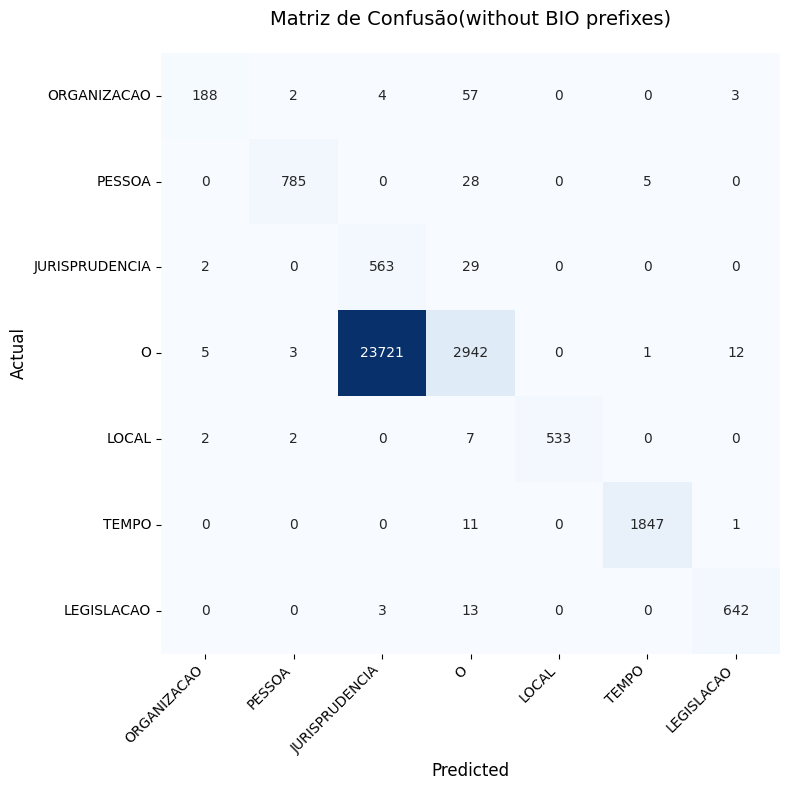

In [54]:
#Plote a matriz de confusão passando as listas y_true_flat, y_pred_flat e as labels que estão em classes
plot_confusion_matrix(y_true_flat, y_pred_flat, labels=classes, title = 'Matriz de Confusão')

## Perguntas

Responda cada uma das perguntas abaixo justificando.

1.   O modelo bidirecional empilhado foi melhor que os modelos anteriores?
  Sim. A combinação de LSTM (para lidar com dependências de longo prazo) e camadas bidirecionais (para usar contexto em ambas as direções) resulta no modelo mais poderoso para tarefas de processamento de sequências como NER.
3.   Foram necessárias mais épocas para que o modelo performasse melhor que os anteriores?
  Sim. A complexidade do modelo é significativamente maior, e mais épocas são necessárias para treinar todos os parâmetros. O monitoramento da perda é fundamental para evitar a captura com perda de novos dados e encontrar o ponto de parada ideal.
2.   Quais classes mais sofrem com falsos positivos e falsos negativos?
  Mais falsos positivos é a classe 'Jurisprudencia' e a classe com maior falsos neativos "O".